In [1]:
import pandas as pd
import numpy as np

In [2]:
from tensorflow import keras

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
from IPython.display import clear_output

In [5]:
from matplotlib import pyplot as plt

In [6]:
from itertools import product

# Data preparation

In [7]:
data = pd.read_csv(
    "/cluster/scratch/bramva/deep-learning-course/data/census-income/census-income.data",
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "income",
    ],
)

In [8]:
categoricals = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
    "income",
]

In [9]:
data.describe(include="all")

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [10]:
data.iloc[0, :]

age                           39
workclass              State-gov
fnlwgt                     77516
education              Bachelors
education-num                 13
marital-status     Never-married
occupation          Adm-clerical
relationship       Not-in-family
race                       White
sex                         Male
capital-gain                2174
capital-loss                   0
hours-per-week                40
native-country     United-States
income                     <=50K
Name: 0, dtype: object

In [11]:
for categorical in categoricals:
    data[categorical] = LabelEncoder().fit_transform(data[categorical])
    values = data[categorical].unique()
    np.random.shuffle(values)
    data[categorical] = values[data[categorical]]

In [12]:
means = data.mean()

In [13]:
data -= means

In [14]:
stds = data.std()

In [15]:
data /= stds

In [16]:
dataset = data.values

In [17]:
ordering = np.arange(dataset.shape[0])
np.random.shuffle(ordering)
dataset = dataset[ordering]

In [18]:
cutoff = round(dataset.shape[0] * .1)

In [19]:
x_train, y_train = dataset[:, 1:], dataset[:, 0]
x_train, x_validate = x_train[cutoff:, :], x_train[:cutoff, :]
y_train, y_validate = y_train[cutoff:], y_train[:cutoff]

In [20]:
x_train.shape, y_train.shape, x_validate.shape, y_validate.shape

((29305, 14), (29305,), (3256, 14), (3256,))

In [21]:
half_validate = round(x_validate.shape[0] / 2)

# Utilities

In [22]:
class PlotLosses(keras.callbacks.Callback):
    def __init__(
        self,
        metrics=None,
        validation=True,
    ):
        self.metrics = ["loss"]
        if metrics:
            self.metrics += metrics
        if validation:
            for i in reversed(range(len(self.metrics))):
                self.metrics.insert(i + 1, "val_" + self.metrics[i])
        self.hist_metrics = [list() for metric in self.metrics]
        
    def on_train_begin(self, logs={}):
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        for metric, hist_metric in zip(self.metrics, self.hist_metrics):
            hist_metric.append(logs.get(metric))

        clear_output(wait=True)
        
        self.fig = plt.figure(figsize=(15, 7))
        for metric, hist_metric in zip(self.metrics, self.hist_metrics):
            plt.plot(range(len(self.hist_metrics[0])), hist_metric, label=metric)
        plt.legend()
        plt.show()

    def __len__(self):
        return len(self.hist_metrics[0])

# Model

In [23]:
def build_model(
    include_random_layers=[],
    include_layers=[],
):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(x_train.shape[1])))
    
    for random_layer_size in include_random_layers:
        model.add(keras.layers.Dense(
            random_layer_size,
            activation="tanh",
            trainable=False,
        ))
    
    for layer_size in include_layers:
        model.add(keras.layers.Dense(
            layer_size,
            activation="tanh",
        ))
        
    model.add(keras.layers.Dense(1))
    return model

In [24]:
sizes = [100, 1_000]
max_depth = 3

def model(random_layers): return build_model(random_layers, [100, 10])
models = [model([])]
for random_size, size in product(sizes, sizes):
    for i in range(1, max_depth + 1):
        models.append(build_model([random_size] * i, [size, 10]))

In [25]:
for model in models:
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
    )

In [26]:
for model in models:
    model.build()
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1500      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               1500      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
________________________________

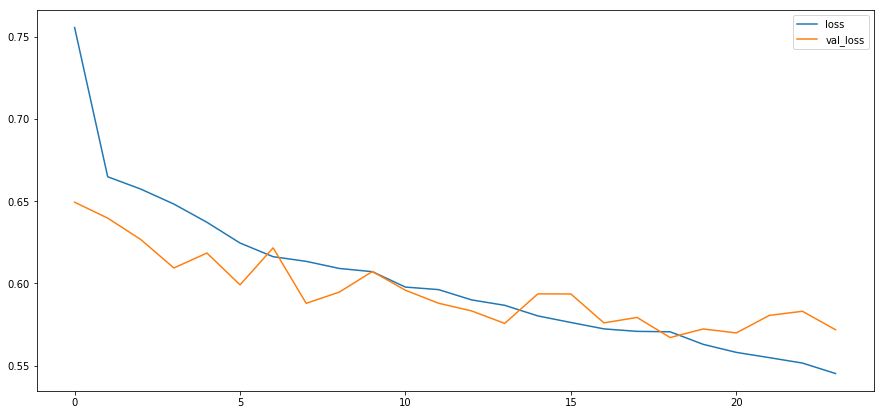

29305/29305 [==============================] - 4s 128us/sample - loss: 0.5452 - val_loss: 0.5718


In [27]:
for i, model in enumerate(models):
    print(i)
    model.fit(
        x_train, y_train,
        32,
        epochs=50,
        shuffle=True,
        validation_data=(
            x_validate[:half_validate], y_validate[:half_validate],
        ),
        callbacks=[
            keras.callbacks.EarlyStopping(
                patience=5,
                restore_best_weights=True,
            ),
            PlotLosses(),
        ],
    )

In [28]:
results = [
    model.evaluate(
        x_validate[half_validate:], y_validate[half_validate:],
        verbose=0,
    ) for model in models
]

In [29]:
for model, result in zip(models, results):
    model.summary()
    print("\n", "score:", result, "\n\n")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1500      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________

 score: 0.5524181252029663 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               1500      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_